In [2]:
from pylab import *
from matplotlib.pyplot import imshow
import numpy as np
import cv2
import warnings
import os

warnings.simplefilter("ignore")

In [3]:
def readNames(path):
    fileList = os.listdir(path)
    return fileList

def readFile(path,filename):
    base = cv2.imread(os.getcwd() + '/' + path + filename)
    base = cv2.cvtColor(base, cv2.COLOR_RGB2BGR)
    return base

In [4]:
def preProcess(base):   
    
    #base = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    #base = cv2.cvtColor(base, cv2.COLOR_RGB2BGR)
    #img = cv2.GaussianBlur(base, (3,3), 0)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(base, cv2.COLOR_RGB2HSV)
    img = cv2.medianBlur(img, 3)
    #img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    
    return img

def process(base):
    mask = np.ones((5,5), np.uint8)
    sigma = 0.33
    img=base
    img = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    img = cv2.medianBlur(img, 3)
    img = cv2.Canny(img, 20, 70)
    img = cv2.dilate(img, mask, iterations=1)
    #img = cv2.erode(img, mask, iterations=1)
    #img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, mask)
    
    return img

In [5]:
def showImg(base, image):
    fig = figure(figsize=(20,10))
    subplot(1,2,1)
    imshow(base)
    subplot(1,2,2)
    imshow(image)

In [8]:
#czy pixele mieszcza sie w przedzialach hsv dla czerwonego

def isRed(mask, upper = 7):
    lowerRed_1 = np.array([0,100,100])
    upperRed_1 = np.array([upper,255,255])
    lowerRed_2 = np.array([175,100,100])
    upperRed_2 = np.array([179,255,255])
    mask1 = cv2.inRange(mask, lowerRed_1, upperRed_1)
    mask2 = cv2.inRange(mask, lowerRed_2, upperRed_2)
    return cv2.addWeighted(mask1,1.0,mask2,1.0,0.0)



#macierz odpowiedzi czy pixele sasiednie sa bardziej czerwone      

def redMask(mask, centre):
    redMask = np.zeros((mask.shape[0],mask.shape[1]), np.uint8)
    constraint = mask[centre,centre,0]
    
    if (constraint<10): constraint += 180
    redpixels = isRed(mask)
    #print('Maska:',mask,'REDPIXELS:',redpixels)
    if (redpixels[centre,centre]>0): 
        for i in range(len(mask)):
            for j in range(len(mask[0])):
                if (mask[i,j,0]<10): red = mask[i,j,0] + 180
                else: red = mask[i,j,0]
                #print('REDMASK')
                #print(redpixels, red, constraint)
                
                #czy pixel jest czerwony i jego kolor jest mniej czerwony od koloru srodka maski
                if (redpixels[i,j]>0 and red<constraint):
                    redMask[i,j] = 1

                
    return redMask


#maska sprawdzajaca sasiedztwo pixela i klasyfikujaca naczynie krwionosne

def maskFilter(img, size = 5):
    #mask = np.ones((size, size), np.uint8)
    
    
    newImg = np.zeros(img.shape, np.uint8)
    newImg[:,:,:] = 0
    side = int(size/2)
    for i in range(side, len(img) - side): #raws
        for j in range(side, len(img[0]) - side): #columns
            mask = img[i-side:i+side+1,j-side:j+side+1,:]
            
            #media = (sum(mask[:,:,0]) - mask[side,side,0])/(mask.shape[0]*mask.shape[1]-1)
            if (mask[side,side,2]>100):
                reds = redMask(mask, side)
                if (sum(reds) > int(reds.size/2)):
                    newImg[i,j,:] = 255
                
    return newImg
    

In [ ]:
def addVeinToImage(image, foundVeinImage):
    outputImage = image.copy()
    for i in range(len(image)):
        for j in range(len(image[i])):
            if foundVeinImage[i,j] == 255:
                outputImage[i,j] = [255,255,255]
                
    return outputImage

In [ ]:
def meanError(image, dataFile):
    if image.shape != dataFile.shape:
        return 0
    
    error = 0.0
    for i in range(len(image)):
        for j in range(len(image[i])):
            error = error + (image[i,j]-dataFile[i,j])**2
            
    error = error / (dataFile.shape[0]*dataFile.shape[1])
    
    return error

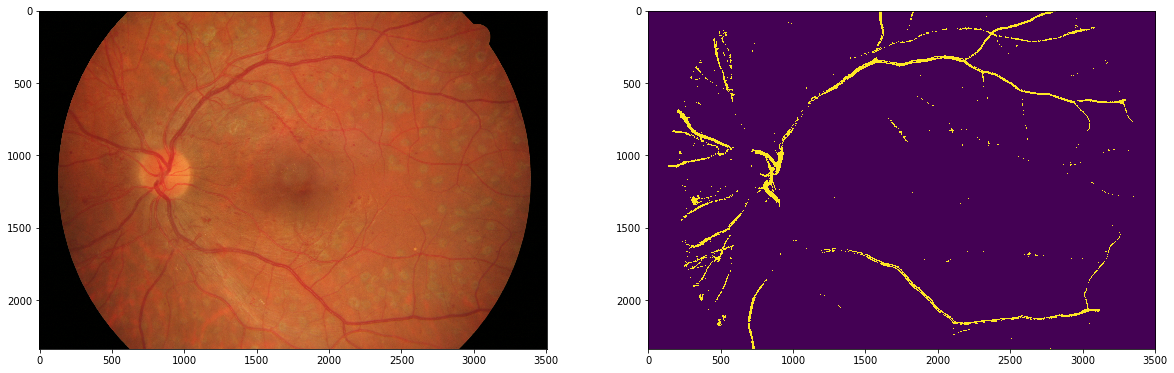

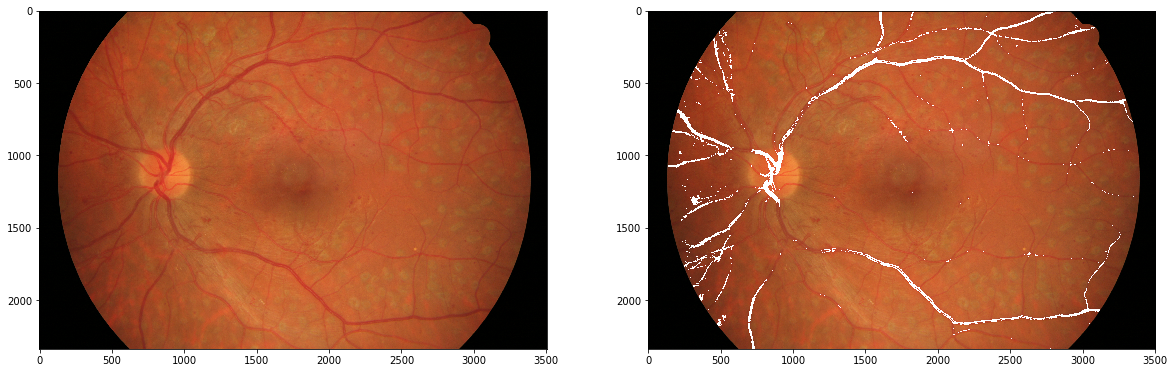

In [10]:
path = 'HRF/images/'
fileList = readNames(path)
image = readFile(path,fileList[1])
img = preProcess(image)
a = isRed(img, upper = 5)
showImg(image,a)

veinImage = addVeinToImage(image, a)

showImg(image,veinImage)

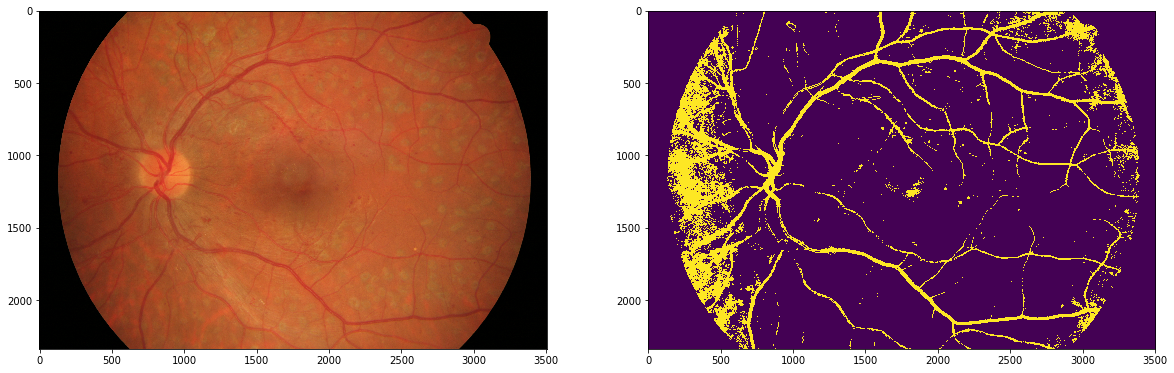

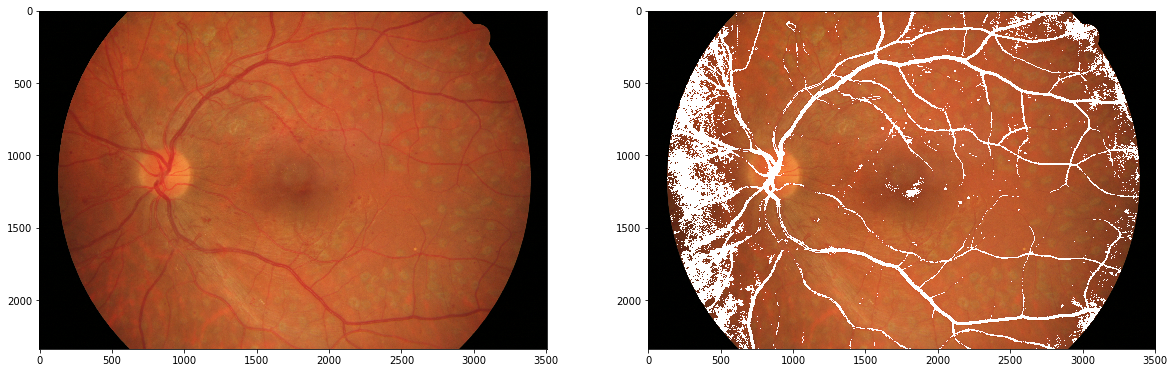

In [11]:
path = 'HRF/images/'
fileList = readNames(path)
image = readFile(path,fileList[1])
img = preProcess(image)
a = isRed(img)
showImg(image,a)

veinImage = addVeinToImage(image, a)

showImg(image,veinImage)

In [12]:
path = 'HRF/images/'
fileList = readNames(path)
image = readFile(path,fileList[1])
img = preProcess(image)
a = maskFilter(img)
showImg(image,a)

veinImage = addVeinToImage(image, a)

showImg(image,veinImage)

KeyboardInterrupt: 

In [ ]:
path = 'HRF/images/'
fileList = readNames(path)
image = readFile(path,fileList[0])
a = process(image)
showImg(image,a)

veinImage = addVeinToImage(image, a)

showImg(image,veinImage)